# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

#J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [8]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y      # 3x² - 2xy + 3y²

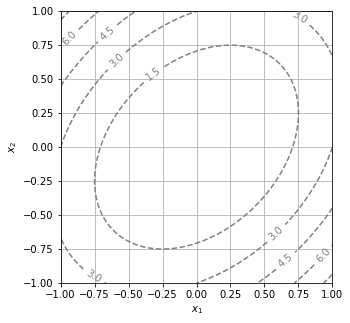

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=5 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [10]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

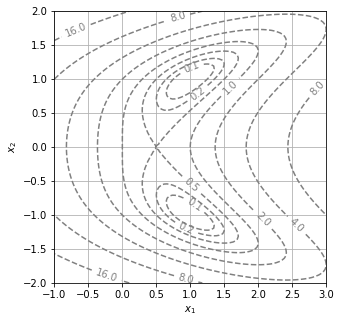

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y)       # sin(x+y) - cos(xy) - 1 + (x² + y²)/1000

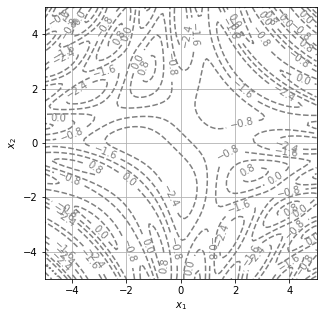

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [14]:
N = 100
eps = 0.01    # précision pas trop grande, on veut juste l'allure des lignes de niveau

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [270]:
def Newton(F, x0, y0, eps=eps, N=N):
    
    J_F = J(F)
    eps2 = eps*eps
    
    for i in range(N):
        x, y = np.array([x0,y0]) - np.linalg.solve(J_F(x0, y0),F(x0,y0))
        if (x - x0)**2 + (y - y0)**2 <= eps2:
            return x, y
        x0, y0 = x, y
    
    else:
        raise ValueError(f"no convergence in {N} steps.")
        
Newton = np.vectorize(Newton)

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de lutiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de repésenter graphiquement les résultats.

### Réponse
Les contraintes supplémentaires seront de la forme $x - y = \delta$. \
On partira toujours d'un point qui vérifie cette contrainte (aucune idée de l'intérêt réel mais ça paraît pas stupide). \
On cherchera quelques autres lignes de niveau.

$f_{1}$ étant symétrique, on se restreint à une moitié de plan.

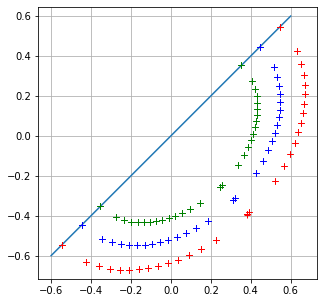

In [273]:
def F_delta(delta, niveau):
    def F(x,y) : 
        return np.array([f1(x,y) - niveau, x - y - delta])
    return F

def trace(niveau, couleur):
    X0 = np.linspace(-1, 1, 10)
    DELTA = np.linspace(0, niveau/2, 15)  # si f(x,y) = c, alors |x - y| <= sqrt(c/2) d'où delta_max = sqrt(c/2)
    DELTA = np.sqrt(DELTA)                # appliquer sqrt après donne une répartition des points plus uniforme le long de la ligne de niveau
    
    for delta in DELTA :
        def Newton_delta(x): 
            return Newton(F_delta(delta, niveau), x, x - delta)
        Sol = Newton_delta(X0)
        plt.plot(Sol[0], Sol[1], color = couleur, marker = '+', ls = '')
    
    return None

def plot_():
    plt.plot([-0.6,0.6],[-0.6,0.6])    # droite x + y = 0
    plt.grid(True)
    plt.axis('equal')

    trace(0.5, 'g')
    trace(0.8, 'b')
    trace(1.2, 'r')

plot_()
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

### Réponse
A partir du point $(x_{0},y_{0})$, on part de $\delta$ vers la droite (perpendiculairement au gradient), puis on applique `Newton` avec la condition de rester à une distance $\delta$ du point $(x_{0},y_{0})$.

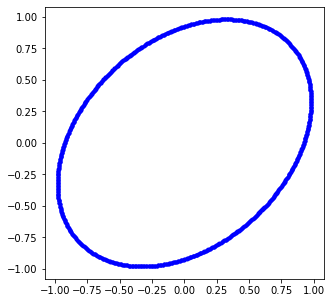

In [23]:
def level_curve(f, x0, y0, delta=0.3, N=1000, eps=eps):
    #on définit une fonction qui renvoie un vecteur de norme delta perpendiculaire (vers la droite) à grad(x,y)
    def Pg_f(x,y):
        g_fxy = grad(f)(x,y)
        norm = np.linalg.norm(g_fxy)
        return delta * np.array([g_fxy[1],-g_fxy[0]])/norm
    
    P = [[x0,y0]]
    c, delta2 = f(x0,y0), delta**2
    
    for _ in range(N-1):
        def F(x,y) : 
            return np.array([f(x,y) - c, (x-x0)**2 + (y-y0)**2 - delta2])
        x1, y1 = np.array([x0, y0]) + Pg_f(x0,y0)
        x0, y0 = Newton(F,x1,y1)
        P.append([x0,y0])
    
    return np.array(P)
        
C = level_curve(f1, 0.8, 0.8)
plt.plot(C[:,0], C[:,1], 'b.')
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

### Réponse
On modifie la boucle en vérifiant à chaque itération si le nouveau point $P$ est assez proche de $P_{0} = (x_{0},y_{0})$, plus précisément si
$dist(P, P_{0}) < \delta/2$, au quel cas on s'arrête car on considère qu'on a fait un tour.
Avec cette vérification, le parcourt de la ligne de niveau peut s'arrêter avant la fin si la ligne de niveau et le point
de départ sont très particuliers. Par exemple :
 - ligne de niveau : contour de la coupe d'un sablier (avec moins de $\delta/2$ de largeur au niveau de l'étranglement)
 - point de départ $P_{0}$ au niveau du goulot d'étranglement
On s'arrête alors quand on repasse de l'autre côté de l'étranglement, en ayant fait le tour que d'un seul bulbe. Pour remédier à
ce problème, il faudrait de prendre $\delta$ plus petit.

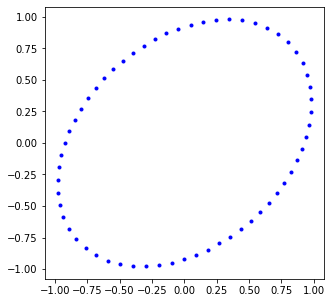

In [35]:
def level_curve2(f, x0, y0, delta=0.1, eps=eps):
    #on définit une fonction qui renvoie un vecteur de norme delta perpendiculaire (vers la droite) à grad(x,y)
    def Pg_f(x,y): 
        g_fxy = grad(f)(x,y)
        norm = np.linalg.norm(g_fxy)
        return delta/norm * np.array([g_fxy[1],-g_fxy[0]])
    
    P = [[x0,y0]]
    c, delta2 = f(x0,y0), delta**2
    x, y = x0, y0

    #------------------------------- partie modifiée
    gros_demi_delta2 = 0.51 * delta2
    
    for _ in range(10000):
        def F(a,b) : 
            return np.array([f(a,b) - c, (x-a)**2 + (y-b)**2 - delta2])
        x1, y1 = np.array([x, y]) + Pg_f(x,y)
        x, y = Newton(F,x1,y1)
        
        if (x - x0)**2 + (y - y0)**2 < gros_demi_delta2 : 
            return np.array(P)
        P.append([x,y])   
    #-------------------------------
    return P
    
C = level_curve2(f1, 0.8, 0.8)
plt.plot(C[:,0], C[:,1], 'b.')
plt.show()

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

### Réponse
On imagine que l'on connaît une solution $(x_{0},y_{0})$ telle que $f(x_{0},y_{0}) = c$. Sinon il faut utiliser `Newton` à partir d'un point arbitraire et espérer que ça converge bien.  
On fait appel à la fonction `level_curve` pour déterminer un rectangle assez grand dans lequel plonger notre ensemble K.
On peut alors construire la grille des centres.


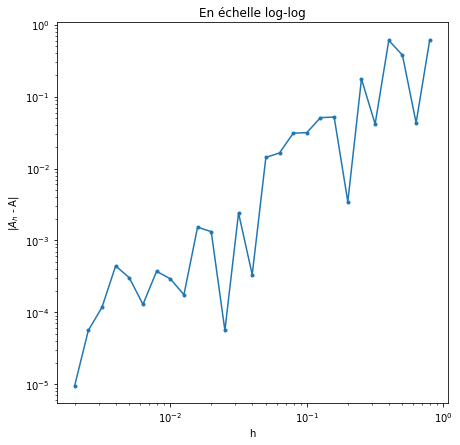

In [299]:
def area_squares(f, h, x0, y0):
  
    #construction du rectangle 
    C = level_curve2(f, x0, y0)
    
    xmin, xmax = np.min(C[:,0]), np.max(C[:,0])
    ymin, ymax = np.min(C[:,1]), np.max(C[:,1])
    
    X = np.arange(xmin - h, xmax + 2*h, h)
    Y = np.arange(ymin - h, ymax + 2*h, h)
                         
    grid = np.zeros((Y.size, X.size, 2))
    grid[:,:,0] = X
    grid[:,:,1] = Y.reshape((Y.size,-1))

    #on vérifie pour chaque centre
    mask = f(grid[:,:,0], grid[:,:,1]) <= f(x0,y0)
    return mask.sum() * h*h
  

def trace():
    
    def U(x,y): return x**2 + y**2
    
    def temporaire(f, h):
        return area_squares(f, h, 1., 0.)
    vectorized =  np.vectorize(temporaire)
    
    H = np.arange(-2.7, 0, 0.1)
    H = np.power(10,H)     # H = [ 10^-2.7, 10^-2.6, 10^-2.5, ... , 10^-0.1 ]

    ERR = abs( vectorized(U, H) - np.pi )
    
    plt.figure(figsize = (7.,7.))
    plt.xscale("log")
    plt.yscale("log")
    plt.plot(H, ERR, '.-')
    plt.title('En échelle log-log')
    plt.xlabel('h')
    plt.ylabel('|'+'$A_{h}$'+' - A|')
    
trace()
plt.show()

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

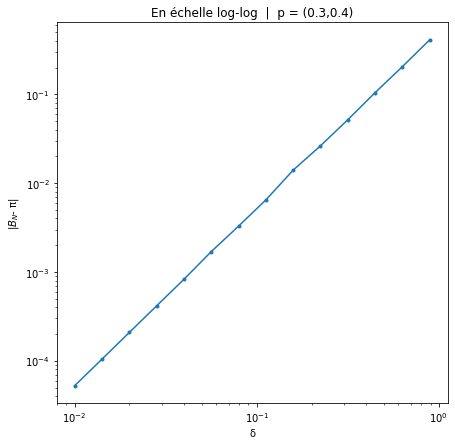

In [300]:
# on utilise la vision géométrique du déterminant comme l'aire (orientée) d'un parallélogramme.

def methode_triangles(Z,p):
    V = Z - p
    V_rolled = np.roll(V, 2)
    return abs(np.cross(V,V_rolled).sum()) / 2



def trace(px, py, legende):
    def U(x,y): return x**2 + y**2
    p = np.array([px,py])
    
    DELTA = np.arange(-2., 0, 0.15)
    DELTA = np.power(10,DELTA) 
    
    ERR = []
    
    for delta in DELTA:
        Z = level_curve2(U, 1., 0., delta=delta)
        ERR.append( abs(methode_triangles(Z, p) - np.pi) )
    
    plt.figure(figsize = (7.,7.))
    plt.xscale("log")
    plt.yscale("log")
    plt.plot(DELTA, ERR, '.-')
    plt.title('En échelle log-log  |  '+legende)
    plt.xlabel('\u03B4')
    plt.ylabel('|'+'$B_{N}$'+'- \u03C0' + '|')

trace(0.3, 0.4, 'p = (0.3,0.4)')
plt.show()

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [278]:
def test(px,py):
    def U(x,y): return x**2 + y**2
    Z = level_curve2(U,1.,0.)
    p = np.array([px, py])
    A = methode_triangles(Z,p)
    print("Aire approximée du cercle unité :", A)
    print("Valeur de l'erreur :", abs(A - np.pi))
    
test(4.,5.)

Aire approximée du cercle unité : 3.136448249213106
Valeur de l'erreur : 0.005144404376687284


### Réponse
Notations :
- Polygone convexe $Z = (z_{0}, z_{1}, ..., z_{N})$ avec $z_{0} = z_{N}$ et $z_{i} = (x_{i},y_{i})$
- Point $p = (x,y)$
- Points $v_{i} = z_{i} - p$

Lorsque l'on fait un dessin, on se rend compte que l'on obtient l'aire exacte du polygone $Z$ avec la méthode des triangles même si le point $p$ est à l'extérieur de $Z$, à condition de compter négativement certaines aires. On peut ensuite remarquer que si l'on additionne les aires des triangles dans l'ordre $(p,z_{0},z_{1})$  $(p,z_{1},z_{2})$  $...$  $(p,z_{N-1},z_{N})$ , il faut changer le signe de l'aire aux moments où l'orientation des bases du plan $(v_{i-1} , v_{i})$ et $(v_{i}, v_{i+1})$ sont différentes.
Cela explique pourquoi la méthode avec les déterminants fonctionne encore.

Exécuter la fonction `dessin` (la cellule juste dessous) illustre cet argument.

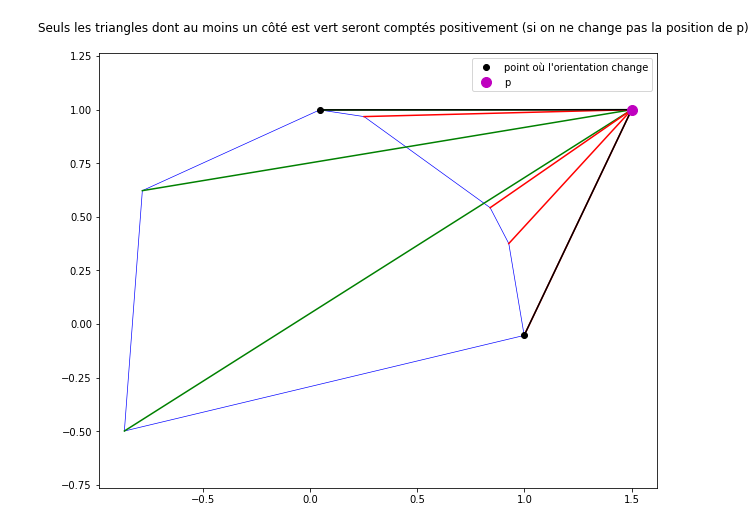

In [292]:
def dessin():
    #construction d'un polygone convexe (tous les sommets sur le cercle unité)
    A = 2*np.pi*np.random.random(7) # angles aléaloires
    A.sort()
    A_ = np.concatenate((A, A[0:1])) # 2 fois le premier point : z0 = zN
    X, Y = np.cos(A_), np.sin(A_)
    Z = np.column_stack((X,Y))
    
    px, py = 1.5, 1.
    p = np.array([px, py])
       
    def signe_des_aires(Z, p):
        V = Z - p
        s = np.cross(V[:-1],V[1:]) > 0    # signes des aires des triangles
        mask = s ^ np.roll(s,1)           # True si z_i est un point où le signe change
        return s, Z[:-1][mask]
    
    def plot_():
        plt.figure(figsize = (10., 8.))
        plt.plot(X, Y, 'b', lw = 2/3)
        
        s, L = signe_des_aires(Z, p)

        for x,y in Z[:-1][s]:
            plt.plot([x,px], [y,py], 'g')

        for x,y in Z[:-1][~s]:
            plt.plot([x,px], [y,py], 'r')

        plt.plot(L[:,0], L[:,1], marker = 'o', color = 'k', ls = '', label = "point où l'orientation change")
        for x,y in L:    
            plt.plot([x,px], [y,py], 'k', lw = 1.5)

        plt.plot(px, py, marker = 'o', ms = 10., color = 'm', ls = '', label = 'p')

        
        plt.legend()
        plt.axis('equal')
        plt.title("""
        Seuls les triangles dont au moins un côté est vert seront comptés positivement (si on ne change pas la position de p)
        """)    
    plot_()
    plt.show()

dessin()

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

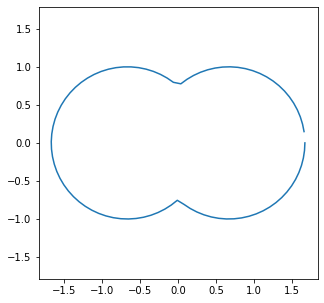

0.6574167724349413 5.589734068478636 4.932317296043695
5.565000000000001


In [269]:
#deux disques de rayon 1 de centres -2/3,0 et 2/3,0

def D1(x,y):
    return (x + 2/3)**2 + y**2

def D2(x,y):
    return (x - 2/3)**2 + y**2

def f(x,y):
    return np.minimum(D1(x,y), D2(x,y))

def test(px,py):
    Z = level_curve2(f, 5/3, 0.)
    plt.plot(Z[:,0], Z[:,1])
    plt.axis('equal')
    plt.show()
    p = np.array([px,py])
    A = methode_triangles(Z,p)
    alpha = np.arccos(2/3) 
    AD = 2*np.pi - 2*(alpha - 2*np.sqrt(5)/27)
    dif = abs(A - AD)
    print(dif,A,AD)
    print(area_squares(f,0.05,5/3,0.))
test(0.,0.)

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)